## 🔑 OpenAI API Key

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_KEY = os.getenv("OPENAI_API_KEY")

## 📚 Imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
from IPython.display import display

import traceback
import re # To clean the LLM Output

## 📥 Load datasets


In [5]:
yt_df = pd.read_csv("../data/youtube_data.csv")
rd_df = pd.read_csv("../data/reddit_data.csv")

## 🧹 Previews


In [6]:
print("🎥 YouTube data shape:", yt_df.shape)
print("📕 Reddit data shape:", rd_df.shape)

🎥 YouTube data shape: (749, 5)
📕 Reddit data shape: (196, 13)


## 🎯 Aggregated Sentiment Analysis


## 📊 What is a KDE Plot?

**KDE** stands for **Kernel Density Estimate**.

- It’s a way to **estimate the probability distribution** of a continuous variable — like sentiment scores.
- Unlike a histogram (which shows bars), a KDE plot shows a **smooth curve** that represents the **density of values**.

> Think of it as a smoothed-out version of a histogram that shows where data points are most concentrated.

---

## 📉 What The Following Plot Shows

The following KDE plot is comparing **sentiment scores** from:

- 🟦 **YouTube Comments**
- 🟧 **Reddit Comments**

Both are plotted on the same X-axis, which represents the **compound sentiment score** from VADER:
- **-1** = very negative
- **0** = neutral
- **+1** = very positive

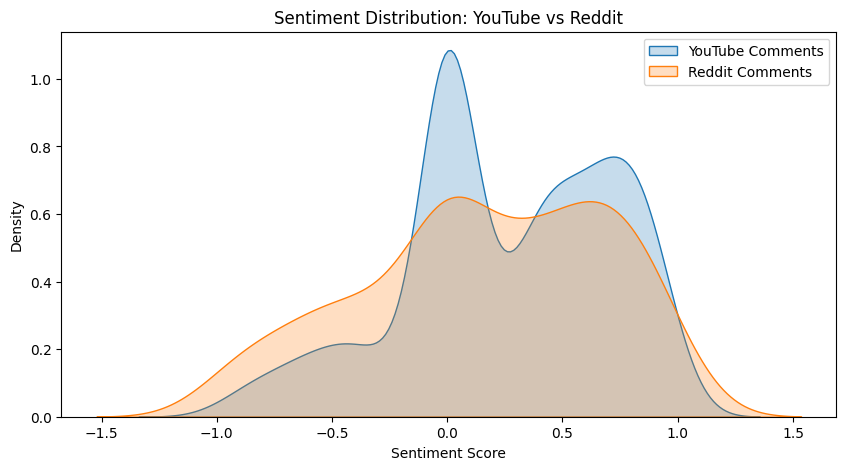

In [7]:
# Create plot
plt.figure(figsize=(10, 5))
sns.kdeplot(yt_df['comment_sentiment'], label='YouTube Comments', fill=True)
sns.kdeplot(rd_df['comment_sentiment'], label='Reddit Comments', fill=True)
plt.title('Sentiment Distribution: YouTube vs Reddit')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()

# ✅ Save BEFORE showing (Otherwise, a blank image will be saved)
plt.savefig("../data/sentiment_distribution.png", bbox_inches="tight")

# Then show (for notebook preview)
plt.show()
plt.close()

## 📖 Interpretation

### 1. **YouTube Comments (Blue)**:
- Peaks sharply **just above 0** and again near **0.7**, indicating:
  - A high concentration of **neutral to moderately positive** comments
  - Very few extreme negative comments

### 2. **Reddit Comments (Orange)**:
- Smoother, more spread out
- Covers more of the **negative side** (to the left of 0)
  - Suggests Reddit users express **a wider range of sentiment**, including more negative tones

---

## 🧠 Key Takeaways

- **YouTube** has a **tighter, more positive skew**: Comments tend to be safe, neutral, or supportive.
- **Reddit** shows a **broader sentiment range**, including a noticeable **presence of criticism or sarcasm**.
- This supports the idea that Reddit discussions are more **opinionated**, while YouTube comments are often more surface-level or appreciative.

## 📊 Average Sentiment Comparison


In [8]:
avg_sentiments = pd.DataFrame({
    'Platform': ['YouTube', 'Reddit'],
    'Avg Comment Sentiment': [yt_df['comment_sentiment'].mean(), rd_df['comment_sentiment'].mean()]
})
display(avg_sentiments)

,Platform,Avg Comment Sentiment
0,YouTube,0.257743
1,Reddit,0.159886


## 🧠 Create grouped summaries for LLM


In [9]:
# Instantiating OpenAI
client = OpenAI(api_key=OPENAI_KEY)

In [10]:
topics = yt_df['video_title'].unique()
final_outputs = []

for topic in topics:
    yt_comments = yt_df[yt_df['video_title'] == topic]['comment'].dropna().tolist()
    reddit_rows = rd_df[rd_df['youtube_title'] == topic]
    reddit_post = reddit_rows['reddit_post_title'].unique()[0] if not reddit_rows.empty else "No Reddit post found"
    reddit_comments = reddit_rows['comment'].dropna().tolist()

    if not yt_comments and not reddit_comments:
        continue

    # ✅ Cleaned, limited comments for brevity
    yt_sample = "\n- ".join(yt_comments[:3])
    rd_sample = "\n- ".join(reddit_comments[:3])

    # ✅ Full prompt passed to model
    user_prompt = f"""
Video Title: {topic}
Reddit Post Title: {reddit_post}

🟦 YouTube Comments:
- {yt_sample}

🟥 Reddit Comments:
- {rd_sample}
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are a social media analyst. Analyze public perception around this topic using the comments from YouTube and Reddit. Provide a concise summary and highlight any sentiment trends or contrasting opinions between platforms."
                },
                {
                    "role": "user",
                    "content": user_prompt.strip()
                }
            ],
            temperature=0.7
        )
        output = response.choices[0].message.content
    except Exception as e:
        output = f"⚠️ Error for topic: {topic} | {str(e)}"
        print(traceback.format_exc())

    final_outputs.append({
        "topic": topic,
        "reddit_post_title": reddit_post,
        "llm_analysis": output
    })

## 📋 Show results

In [11]:
llm_df = pd.DataFrame(final_outputs)

# Using Regular Expressions to clean the LLM Output
def clean_llm_output(text):
    # Remove Markdown bold/italic
    text = re.sub(r"\*\*(.*?)\*\*", r"\1", text)
    text = re.sub(r"\*(.*?)\*", r"\1", text)
    # Remove Headers
    text = re.sub(r"\#+", r"", text)
    # Remove newlines and excessive spacing
    text = re.sub(r"\n+", "\n", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text.strip()

# Applying the cleaning function to the 'llm_analysis' column
llm_df['llm_clean_analysis'] = llm_df['llm_analysis'].apply(clean_llm_output)

llm_df.head()

,topic,reddit_post_title,llm_analysis,llm_clean_analysis
0,FULL SEGMENT: Randy Orton ROCKS John Cena with...,Post WWE Raw 4/21/2025 Show Discussion Thread ...,### Summary:\n\nThe public perception of the W...,Summary:\nThe public perception of the WWE Raw...
1,Can We Beat Josh Allen & Jon Rahm in a Golf Ma...,I’m pretty sure my Wife’s DM hates me.,The public perception around the YouTube video...,The public perception around the YouTube video...
2,"Carrie Underwood Praises with ""How Great Thou ...",No Reddit post found,Based on the YouTube comments provided for the...,Based on the YouTube comments provided for the...
3,Watch the Destiny 2: The Edge of Fate Reveal o...,Destiny 2: The Edge of Fate Reveal May 6th,**Public Perception Summary:**\n\n**YouTube Co...,Public Perception Summary:\nYouTube Comments:\...
4,skibidi toilet 78,I just watched skibidi toilet 78,Based on the comments from both YouTube and Re...,Based on the comments from both YouTube and Re...


In [12]:
for llm_analysis in llm_df['llm_clean_analysis']:
    print(llm_analysis, end="\n\n\n")

Summary:
The public perception of the WWE Raw segment featuring Randy Orton's RKO on John Cena is enthusiastic and positive, with a focus on the entertainment value and excitement of the match. YouTube Comments:
- Sentiment: The comments are generally positive and express excitement, especially regarding Randy Orton's move. One comment specifically thanks Orton for delivering the RKO, suggesting that it was a satisfying moment for viewers. The comments, however, are sparse and lack depth, focusing more on the action itself rather than providing detailed opinions or analysis. Reddit Comments:
- Sentiment: The discussion on Reddit is more analytical and broader in scope. Fans are engaged in discussing other aspects of the WWE universe, such as character roles and potential faction developments. The comments reflect enthusiasm for character dynamics and potential storylines, suggesting a deeper engagement with the overall narrative of WWE rather than just the specific match. Sentiment Tre

## Saving to csv

In [13]:
llm_df.to_csv("../data/llm_insights.csv", index=False)